In [1]:
%matplotlib notebook

import sys
import logging
import numpy as np
import math
import matplotlib.pyplot as plt

import sys

sys.path.append("../DesignTool/")
sys.path.append("../DesignTool/smdtLibs/")

import targets
import maskDesignFile
import maskLayouts
import configFile
import DARCalculator
import Test_All_Input
import utils
import drawUtils

import DistortionUtil

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
config = configFile.getDefaultConfig()

In [3]:
layout = maskLayouts.MaskLayouts["deimos_no_gap"]
layoutMM = maskLayouts.scaleLayout(layout, utils.AS2MM, 0, -targets.ZPT_YM)
guiderLayout = maskLayouts.GuiderFOVs["deimos"]
guiderLayoutMM = maskLayouts.scaleLayout(guiderLayout, utils.AS2MM, 0, -targets.ZPT_YM)

In [4]:
Test_All_Input.Test_Inputs.keys()

dict_keys(['dec0Pa0a', 'dec0Pa30a', 'dec0Pa75a', 'dec0Pa45a', 'dec0Pa90a', 'dec0Pa60a', 'dec0Pa15a', 'dec0Pa105a', 'dec0Pa150a', 'dec0Pa120a', 'dec0Pa135a', 'dec0Pa180a', 'dec0Pa165a', 'dec0Pa0', 'dec0Pa105', 'dec0Pa120', 'dec0Pa135', 'dec0Pa15', 'dec0Pa150', 'dec0Pa165', 'dec0Pa180', 'dec0Pa30', 'dec0Pa45', 'dec0Pa60', 'dec0Pa75', 'dec0Pa90', 'M53_GAIA_Gmag_le_16_hp4_out', 'M53_GAIA_Gmag_le_16_hp0_out', 'LeoIa', 'n2419c', 'denseOverlappingMask', 'denseNoOverlappingMask', 'denseOverlappingPa90Mask', 'denseNoOverlappingPa90Mask', 'denseNoOverlapPa270', 'denseNoOverlapPa180', 'NoOverlapPa180L4500', 'NoOverlapPa270L4500', 'NoOverlapPa90L4500'])

In [5]:
designInfo = Test_All_Input.Test_Inputs["M53_GAIA_Gmag_le_16_hp0_out"]
FileName, raStr, decStr, paDeg, haDeg, flag = designInfo

In [6]:
mdf = maskDesignFile.MaskDesignInputFitsFile(FileName)

allTargets = mdf.allSlits  # .sort_values("slitX1")
inDsims = allTargets[np.logical_and(allTargets.slitTyp == "P", allTargets.dSlitId > 0)]
dsimXs, dsimYs = mdf.getObjOnSlit(inDsims)

In [42]:
tlist = targets.TargetList(FileName.replace(".fits", ".out"), config=config)

selectedTargets = tlist.targets
selectedTargets['OBEJCT'] = selectedTargets.objectId
tlist.markInside()
selectedTargets = selectedTargets[selectedTargets.inMask > 0]
selectedTargets = selectedTargets[selectedTargets.selected > 0]
alignBoxes = selectedTargets[selectedTargets.pcode == -2]

selectedTargets = selectedTargets[selectedTargets.pcode > 0]
calcXs, calcYs = selectedTargets.xmm, selectedTargets.ymm

In [45]:
calcXs.index, dsimXs.index

(Int64Index([ 2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 17, 18, 20, 21, 22,
             23, 24, 25, 26, 27, 30, 31, 32, 33, 34, 35, 37],
            dtype='int64'),
 Int64Index([ 2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 17, 18, 20, 21, 22,
             23, 24, 25, 26, 27, 30, 31, 32, 33, 34, 35, 37],
            dtype='int64'))

In [9]:
inBoth = calcXs.index.join(dsimXs.index, how="inner")
calcXs, calcYs, dsimXs, dsimYs = [x[inBoth] for x in (calcXs, calcYs, dsimXs, dsimYs)]
print("len ", len(calcXs))

len  29


In [10]:
pfx, pfy = tlist.getDistortionFunctions()
calcXs1, calcYs1 = pfx(calcXs, calcYs), pfy(calcXs, calcYs)

<IPython.core.display.Javascript object>


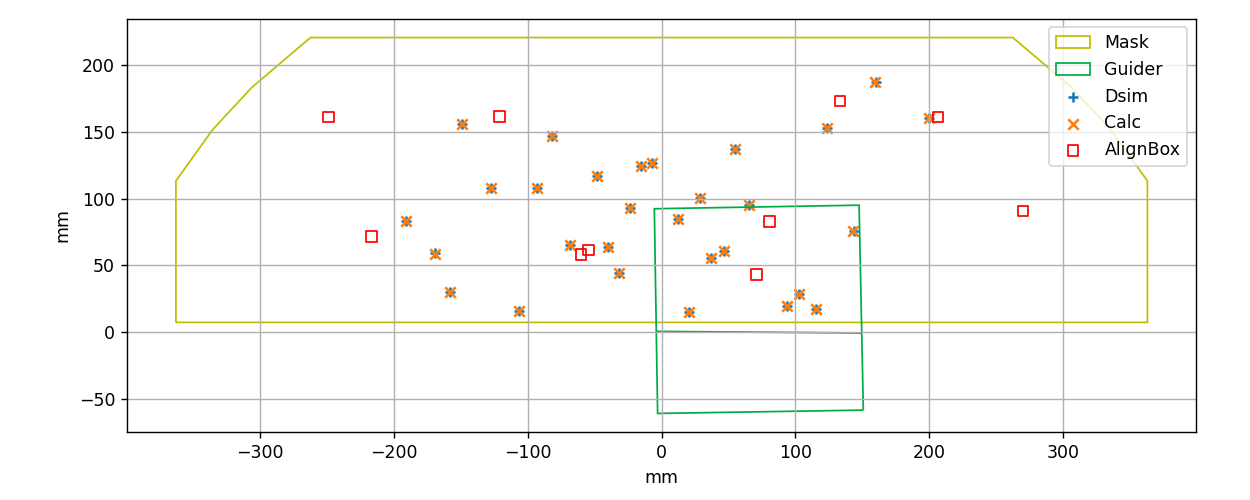

In [11]:
plt.figure(figsize=(10, 4))
plt.gca().set_aspect("equal")
plt.scatter(dsimXs, dsimYs, marker="+", label="Dsim")
plt.scatter(calcXs1, calcYs1, marker="x", label="Calc")
plt.scatter(
    alignBoxes.xmm, alignBoxes.ymm, marker="s", ec="r", fc="None", label="AlignBox"
)


p1 = drawUtils.drawPatch(plt.gca(), layoutMM, fc="None", ec="y")
p1.set_label("Mask")
p2 = drawUtils.drawPatch(plt.gca(), guiderLayoutMM, fc="None", ec="#00aa44")
p2.set_label("Guider")

plt.grid()
plt.xlabel("mm")
plt.ylabel("mm")
plt.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


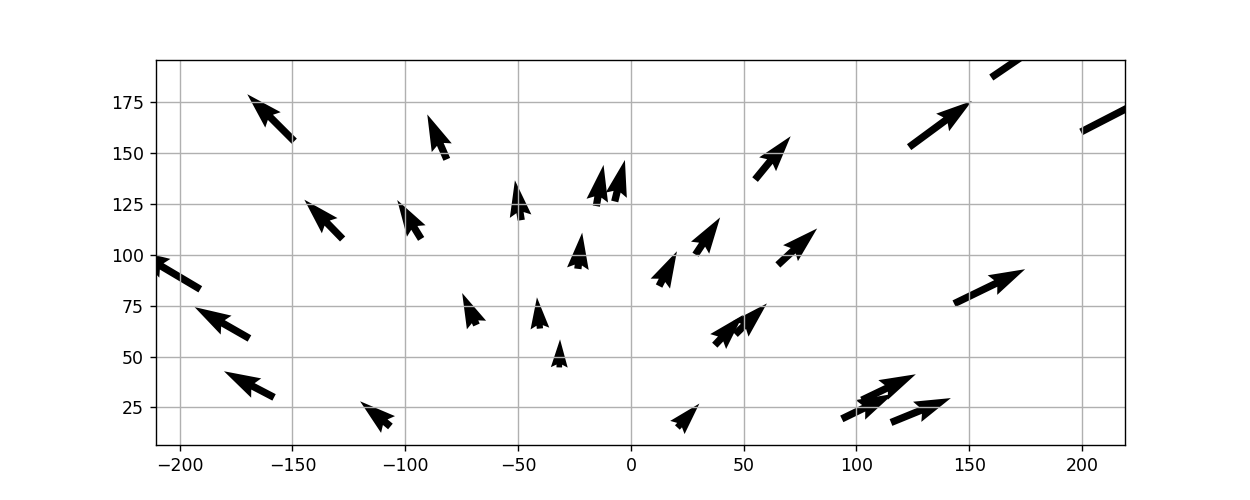

In [38]:
plt.figure(figsize=(10, 4))

plt.gca().quiver(
    calcXs1,
    calcYs1,
    dsimXs - calcXs1,
    dsimYs - calcYs1,
    #scale=0.02,
    #scale_units="xy",
    #headwidth=1.0,
    #headlength=0.10,
)
plt.grid()